In [1]:
# SVM with kernels, exemplified for some types and hyperparameters
# version: stable and fast
# applied to breast cancer database
# normalization fixed
# Jan Nagler, May 2020

import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, validation_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
#plt.rcParams['figure.figsize'] = (10,10)

In [2]:
#Load dataset
cancer = datasets.load_breast_cancer()

# Convert to df
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)

# Split to X and y
X = cancer.data
y = cancer.target

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
                                    X,y, test_size=0.3, random_state=330)

In [3]:
#print(y.sum())
print(df.shape) 
#print(df.head()) # generates ugly output
df.head() # better

(569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [11]:
# fixed: normalization is faster and should be done here anyway
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# fixed: make f2 a valid validation  
def f2_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta=2, pos_label=0, average='binary')
  
f2 = make_scorer(f2_scorer, greater_is_better=True)

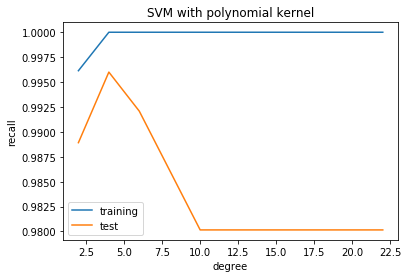

In [5]:
# SVM with polynomial kernel
# for score = recall
# hyperparameters gamma, C and degree, degree is the main one
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
#
num_splits = 5 # use of k-fold is good
svm_poly = svm.SVC(kernel='poly', gamma = 'scale', C=1) # here C is fixed
kfold = KFold(n_splits=5,random_state=7) 
degrees = [2,4,6,10,22] # choose/scan more systematically 
num_values=len(degrees)

train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                              "degree", degrees, cv=kfold, 
                                              scoring = 'recall')
train_scores_poly_recall = pd.DataFrame(data=train_scores, 
                                        index=np.arange(0, num_values), 
                                        columns=np.arange(0,num_splits)) 
valid_scores_poly_recall = pd.DataFrame(data=valid_scores, 
                                        index=np.arange(0, num_values), 
                                        columns=np.arange(0,num_splits)) 

plt.plot(degrees, train_scores_poly_recall.mean(axis=1), label='training')
plt.plot(degrees, valid_scores_poly_recall.mean(axis=1), label='test')
plt.xlabel('degree')
plt.ylabel('recall')
plt.title('SVM with polynomial kernel')
plt.legend()

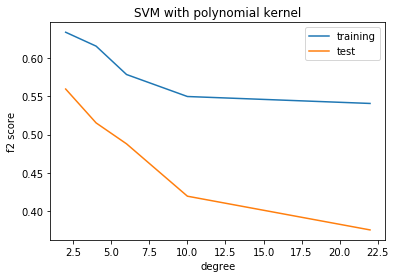

In [6]:
# Same as before but for score = f2
train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                              "degree", degrees, cv=kfold, 
                                              scoring = f2)
train_scores_poly_f2 = pd.DataFrame(data=train_scores, 
                                    index=np.arange(0, num_values), 
                                    columns=np.arange(0,num_splits)) 
valid_scores_poly_f2 = pd.DataFrame(data=valid_scores, 
                                    index=np.arange(0, num_values), 
                                    columns=np.arange(0,num_splits)) 

plt.plot(degrees, train_scores_poly_f2.mean(axis=1), label='training')
plt.plot(degrees, valid_scores_poly_f2.mean(axis=1), label='test')
plt.xlabel('degree')
plt.ylabel('f2 score')
plt.title('SVM with polynomial kernel')
plt.legend()

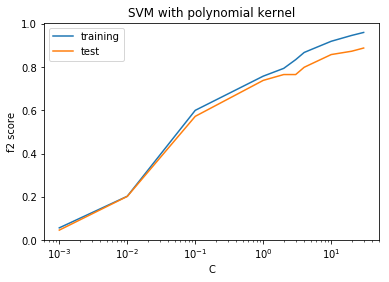

In [7]:
# for the C parameter
num_splits = 5 # use of k-fold is good
svm_poly = svm.SVC(kernel='poly', gamma = 'scale', degree=3) # degree fixed here
kfold = KFold(n_splits=5,random_state=7) 
C = [30, 20, 10, 5, 4, 3, 2, 1, 0.1, 0.01, 0.001]
num_values=len(C)

train_scores_C_f2, valid_scores_C_f2 = validation_curve(svm_poly, X_train, 
                                                        y_train, "C", C, 
                                                        cv=kfold, scoring = f2)
train_scores_C_f2 = pd.DataFrame(data=train_scores_C_f2, 
                                 index=np.arange(0, num_values), 
                                 columns=np.arange(0,num_splits)) 
valid_scores_C_f2 = pd.DataFrame(data=valid_scores_C_f2, 
                                 index=np.arange(0, num_values), 
                                 columns=np.arange(0,num_splits)) 

plt.semilogx(C, train_scores_C_f2.mean(axis=1), label='training')
plt.semilogx(C, valid_scores_C_f2.mean(axis=1), label='test')
plt.xlabel('C')
plt.ylabel('f2 score')
plt.title('SVM with polynomial kernel')
plt.legend()